In [1]:
!pip install standoffconverter
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Part 1: Extracting a cooccurrence graph from stage directions of Shakespeare plays

In [2]:
from standoffconverter import View, Standoff
import requests
import json
import numpy as np
import pandas as pd
from lxml import etree
from functools import partial

## Fetching data from Dracor
We will make use of the open API from dracor to fetch a play by Shakespeare in TEI. Therefore, we first fetch a list of available shakespeare plays using the `get_shake_meta` function.

In [3]:
def get_shake_meta():
  url = 'https://dracor.org/api/corpora/shake/metadata'

  headers = {'Content-Type': 'application/json'}

  response = requests.get(url, headers=headers)

  if response.status_code == 200:
      return pd.DataFrame(json.loads(response.content.decode('utf-8')))
  else:
      return None


In [4]:
shake_meta = get_shake_meta()
shake_meta.head()

,size,wordCountSp,averageClustering,numOfPersonGroups,density,averagePathLength,maxDegreeIds,averageDegree,name,normalizedGenre,diameter,yearPremiered,yearPrinted,maxDegree,numOfSpeakers,wordCountText,yearNormalized,libretto,subtitle,title,numConnectedComponents,wordCountStage,numOfSpeakersUnknown,yearWritten,firstAuthor,id,numOfSpeakersFemale,numOfSegments,numOfSpeakersMale,wikipediaLinkCount,numOfActs,numOfCoAuthors,playName
0,25,17127,0.869870,3,0.683333,1.316667,Titania_MND|RobinGoodfellow_MND,16.400000,a-midsummer-night-s-dream,None,2,None,None,24,25,17772,1595,False,None,A Midsummer Night’s Dream,1,789,3,1595,William Shakespeare,shake000008,5,9,14,61,5,0,a-midsummer-night-s-dream
1,29,24421,0.792775,10,0.312808,1.727513,Parolles_AWW,8.758621,all-s-well-that-ends-well,None,3,None,1623,22,29,25066,1605,False,None,All’s Well That Ends Well,2,826,10,1605,William Shakespeare,shake000012,5,24,14,30,5,0,all-s-well-that-ends-well
2,74,25878,0.815458,22,0.147353,2.080954,Antony_JC,10.756757,antony-and-cleopatra,None,4,None,1623,47,74,27119,1606,False,None,Antony and Cleopatra,2,1407,22,1606,William Shakespeare,shake000035,1,42,33,37,5,0,antony-and-cleopatra
3,28,23113,0.779298,1,0.291005,1.907407,Orlando_AYL|Touchstone_AYL,7.857143,as-you-like-it,None,4,None,1623,18,28,23721,1599,False,None,As You Like It,1,970,3,1599,William Shakespeare,shake000010,4,23,20,43,5,0,as-you-like-it
4,67,28851,0.796710,11,0.163275,1.977415,Coriolanus_Cor,10.776119,coriolanus,None,4,None,1623,54,67,29948,1608,False,None,Coriolanus,2,1460,11,1608,William Shakespeare,shake000026,3,29,45,35,5,0,coriolanus


Next, we just fetch the TEI of the first play in the list and parse it as an lxml etree and then also as a Standoff object.

In [5]:
def get_play_tei(playname):

  url = f'https://dracor.org/api/corpora/shake/play/{playname}/tei'

  headers = {'Content-Type': 'application/xml'}

  response = requests.get(url, headers=headers)

  if response.status_code == 200:
      return etree.fromstring(response.content.decode('utf-8'))
  else:
      return None

In [6]:
playname = shake_meta.iloc[0]["playName"]
play_tei = get_play_tei(playname)
play_so = Standoff(play_tei, namespaces={'tei': 'http://www.tei-c.org/ns/1.0'})

## Preprocessing
We would like to access all text that is a stage direction grouped by the scene that it appers in. We therefore discard all empty elements and extract the corresponding stage and scene information for the remaining elements.

In [7]:
ct = play_so.collapsed_table

In [8]:
ct = ct[ct.T.apply(lambda row: row.text.strip() != '' if row.context[-1].tag != "{http://www.tei-c.org/ns/1.0}c" else True)]

In [9]:
ct['readable_context'] = ct.context.apply(lambda x: ">".join([it.tag[it.tag.index("}")+1:] for it in x]))

In [10]:
ct.iloc[100:110]

,context,text,readable_context
342,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,,text>body>div>div>sp>l>c
344,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,O,text>body>div>div>sp>l>w
346,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,",",text>body>div>div>sp>l>pc
348,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,,text>body>div>div>sp>l>c
350,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,methinks,text>body>div>div>sp>l>w
352,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,,text>body>div>div>sp>l>c
354,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,how,text>body>div>div>sp>l>w
356,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,,text>body>div>div>sp>l>c
358,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,slow,text>body>div>div>sp>l>w
362,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,This,text>body>div>div>sp>l>w


In [11]:
def extract_context_el(context, el_tag, attrib=None):
    
    els = [it for it in context if it.tag == el_tag]
    if attrib is not None:
      els = [it for it in context if attrib[0] in it.attrib and it.attrib[attrib[0]] == attrib[1]]
    if len(els) > 0 :
        return els[0]

extract_stages_el = partial(extract_context_el, el_tag='{http://www.tei-c.org/ns/1.0}stage')
extract_scene_el = partial(extract_context_el, el_tag='{http://www.tei-c.org/ns/1.0}div', attrib=("type", "scene"))
stages = ct.context.apply(extract_stages_el)
scenes = ct.context.apply(extract_scene_el)
ct['stages'] = stages
ct['scenes'] = scenes

We now group the text of the rows based on the `stage` and `scene` information.

In [12]:
grouped_scenes = []

for scene,subdf in ct.groupby('scenes', sort=False):

    c_stage_direction_df = subdf[~subdf.stages.isnull()]

    c_stage_directions = []
    for stage, subsubdf in c_stage_direction_df.groupby('stages', sort=False):
        c_stage_directions.append(' '.join(subsubdf.text))

    grouped_scenes.append({
        'scene': scene,
        'text': c_stage_directions,
    })

grouped_scenes = pd.DataFrame(grouped_scenes)

In [13]:
grouped_scenes.iloc[0].text

['Enter   Theseus ,   Hippolyta ,   and   Philostrate ,   with   others .',
 'Philostrate   exits .',
 'Enter   Egeus   and   his   daughter   Hermia ,   and   Lysander     and   Demetrius .',
 ',   to   Theseus',
 'All   but   Hermia   and   Lysander   exit .',
 'Enter   Helena .',
 'Hermia   exits .',
 'Lysander   exits .',
 'She   exits .']

## Entity recognition
We now use a spacy model to identify Entities and count how often entities appear together in a scene. First, we store it in a sparse, unbounded data format but in a second step, when we know the total number of distinct entities, we convert the cooccurrence data to a adjacency matrix.

In [14]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [15]:
index = []
cooccurrences_list = []
for iscene, scene in grouped_scenes.iterrows():
    for stage in nlp.pipe(scene.text):
        for enti in stage.ents:
            enti = enti.text
            for entj in stage.ents:
                entj = entj.text
                if entj not in index:
                    index.append(entj)
                  
                if enti != entj:
                    cooccurrences_list.append((
                        index.index(enti),
                        index.index(entj),
                    ))

In [16]:
cooccurrences_mat = np.zeros((len(index),len(index)))
for a,b in cooccurrences_list:
    cooccurrences_mat[a,b]+=1

The final adjacency matrix is presented as an image.

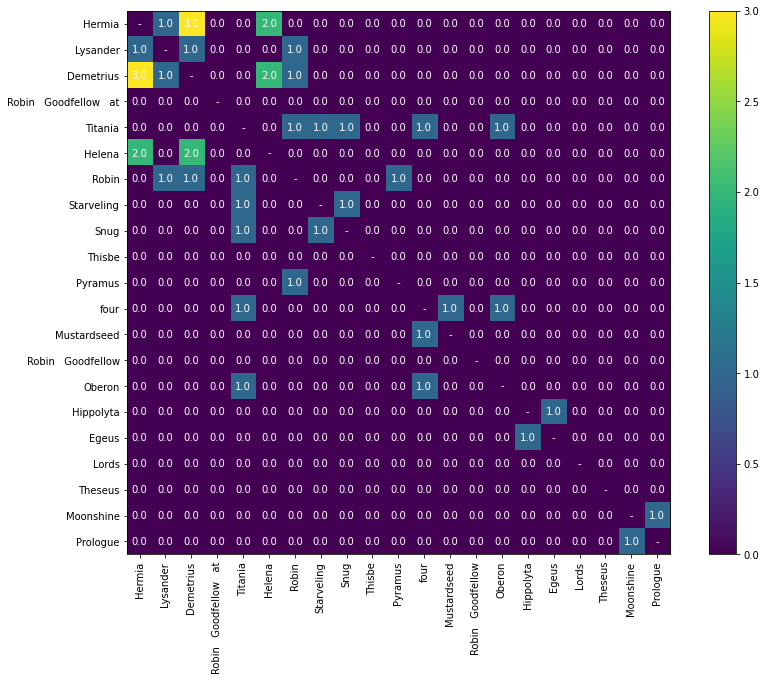

In [17]:
import matplotlib.pyplot as plt


def plot_cooccurrences(mat, index):
    size = len(index)

    # Limits for the extent
    x_start = 0
    x_end = size
    y_start = 0
    y_end = size

    extent = [x_start, x_end, y_start, y_end]

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)
    im = ax.imshow(mat, extent=extent, interpolation='None', cmap='viridis')

    # Add the text
    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (2.0 * size)
    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            label = mat[y_index, x_index]
            text_x = x + jump_x
            text_y = y + jump_y
            if y_index!=x_index:
                ax.text(text_x, size-text_y, label, color='white', ha='center', va='center')
            else:
                ax.text(text_x, size-text_y, "-", color='white', ha='center', va='center')

    ax.set_xticks(np.arange(x_start, x_end)+.5)
    ax.set_xticklabels([s for s in index], rotation=90)

    ax.set_yticks(np.arange(x_start, x_end)+.5)
    ax.set_yticklabels([s for s in index[::-1]])


    fig.colorbar(im)
    return fig
_ = plot_cooccurrences(cooccurrences_mat, index)

# Part 2: Detecting stage directions

In [18]:
grouped_chunks = []
buffer = {"text": [], "stage":None}
c_stage = None
for irow, row in ct.iterrows():
    context = [it.tag for it in row.context]
    if (
        "{http://www.tei-c.org/ns/1.0}sp" not in context
        and "{http://www.tei-c.org/ns/1.0}stage" not in context
        or "{http://www.tei-c.org/ns/1.0}speaker" in context
        ):
        continue
    if c_stage != row.stages:
        for sent in nlp("".join(buffer['text'])).sents:
            grouped_chunks.append({
                "text": sent.text,
                "stage": buffer['stage']
            })
        buffer = {"text": [], "stage":None}
        c_stage = row.stages
    buffer['text'].append(row.text)
    buffer['stage'] = c_stage is not None

if len(buffer)>0:
    for sent in nlp(" ".join(buffer['text'])).sents:
        grouped_chunks.append({
            "text": sent.text,
            "stage": buffer['stage']
        })
grouped_chunks = pd.DataFrame(grouped_chunks)

In [19]:
grouped_chunks.iloc[0].text

'Enter Theseus, Hippolyta, and Philostrate, with others.'

In [20]:
grouped_chunks.to_csv('stage_directions.csv',index=False)

from google.colab import files
files.download('stage_directions.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
ct.iloc[401:403]

,context,text,readable_context,stages,scenes
1002,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,,text>body>div>div>sp>l>c,None,"[[[], [], []], [[], [], [], [], [], [], [], []..."
1004,[[[<Element {http://www.tei-c.org/ns/1.0}castL...,thee,text>body>div>div>sp>l>w,None,"[[[], [], []], [[], [], [], [], [], [], [], []..."


In [23]:
seed = 38383
dataset = grouped_chunks.sample(frac=1,random_state=seed).reset_index(drop=True)

true_ = dataset[dataset.stage==1]
false_ = dataset[dataset.stage==0]
false_subsample = false_[:len(true_)]

dataset = pd.concat([true_, false_subsample])

dataset = dataset.sample(frac=1,random_state=seed).reset_index(drop=True)

In [24]:
dataset

,text,stage
0,"Enter Pyramus (Bottom), and Thisbe (Flute), an...",True
1,Moonshine exits.,True
2,"Come, recreant!",False
3,And look thou meet me ere the first cock crow.,False
4,Thou canst compel no more than she entreat.,False
...,...,...
401,", as Moonshine",True
402,Philostrate exits.,True
403,", as Thisbe",True
404,", as Pyramus",True
